# About
### Author:
    Thiago Luis Rodrigues Pinho @AILAB 
### Start Date:
    17/04/2020
### Objectives:
    Train a Siamese Manhattan Long Short-Term Memory and use it to evaluate text similarity for ALEI project
### Summary:
    1. Loading Data
        1.1 Sampling Data
    2. Treating Data
        2.1 Creating Text Pairs
        2.2 Embedding Text Pairs To Matrixes
    3. Training Siamese ManLSTM
        3.1 Creating and training model
        3.2 Evaluting the optimal number of clusters
    4. Predicting
        4.1 Finding the most similar text
    5. Bibliography
    

# [ALEI] IAgrupador com Siamese Manhattan LSTM (MaLSTM)

In [1]:
from time import time

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from fastparquet import write
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.layers import Input, Embedding, LSTM, GRU, Conv1D, Conv2D, GlobalMaxPool1D, Dense, Dropout

from util import make_w2v_embeddings
from util import split_and_zero_padding
from util import ManDist
%matplotlib inline
plt.style.use('fivethirtyeight')

unable to import 'smart_open.gcs', disabling that module


## 1. Loading data

In [6]:
%%time 
RELATIVE_FOLDER_PATH = "./data/"
VECTOR_MODEL_NAME = "pt_core_news_sm"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
filename = "data_preprocessed"
stopwords_set = set(STOP_WORDS)

parquet_filename = RELATIVE_FOLDER_PATH + filename + ".parquet.gzip"
ailab_df = pd.read_parquet(parquet_filename, columns=['process_class', 'text', 'process_id'])
print(ailab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  2036 non-null   object
 1   text           2036 non-null   object
 2   process_id     2036 non-null   object
dtypes: object(3)
memory usage: 47.8+ KB
None
CPU times: user 4.69 s, sys: 216 ms, total: 4.91 s
Wall time: 4.93 s


## 2. Treating Data

In [7]:
num_samples = 50
sample_df = ailab_df.sample(n=num_samples)
print(sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1389 to 1307
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  50 non-null     object
 1   text           50 non-null     object
 2   process_id     50 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB
None


### 2.1 Creating Text Pairs
It's necessary to prepare data so each input is a pair os texts and if they are close

In [8]:
%time
text_pairs = []
for question_1_index, question_1_row in sample_df.iterrows():
    question_1_text = question_1_row['text']
    question_1_id = question_1_row['process_id']
    question_1_class = question_1_row['process_class']
    for question_2_index, question_2_row in sample_df.iterrows():
        if question_1_index == question_2_index:
            continue
        question_2_text = question_2_row['text']
        question_2_id = question_2_row['process_id']
        question_2_class = question_2_row['process_class']
        is_same_class = question_1_class == question_2_class
        text_pairs.append([question_1_id, question_1_text, question_2_id, question_2_text, is_same_class])

train_df = pd.DataFrame(text_pairs, columns=['question1_id', 'question1', 'question2_id', 'question2', 'is_duplicate'])
print(train_df.info())

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  2450 non-null   object
 1   question1     2450 non-null   object
 2   question2_id  2450 non-null   object
 3   question2     2450 non-null   object
 4   is_duplicate  2450 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 79.1+ KB
None


#### Storing partial results

In [9]:
pair_text_filename = "text_pairs" + str(num_samples)
pair_text_parquet_filename = RELATIVE_FOLDER_PATH + pair_text_filename + ".parquet.gzip"

In [10]:
write(pair_text_parquet_filename, train_df, compression='gzip')

#### Loading partial results

In [11]:
pair_text_df = pd.read_parquet(pair_text_parquet_filename)
print(pair_text_df.head())

  question1_id                                          question1  \
0      1017001  documento recebido eletronicamente origem estj...   
1      1017001  documento recebido eletronicamente origem estj...   
2      1017001  documento recebido eletronicamente origem estj...   
3      1017001  documento recebido eletronicamente origem estj...   
4      1017001  documento recebido eletronicamente origem estj...   

  question2_id                                          question2  \
0      1123769  procuradoriageral municipio jose preto termos ...   
1      1074289  ruedasrueda ementa processo civil embargos dec...   
2       787966  pagina separacao gerada automaticamente regist...   
3      1084106  administrativo expurgos inflacionarios pispase...   
4      1112546  preconiza afastar base calculo piscofins monta...   

   is_duplicate  
0          True  
1          True  
2          True  
3         False  
4         False  


### 2.2 Embedding Text Pairs To Matrixes

In [12]:
%time
for q in ['question1', 'question2']:
    pair_text_df[q + '_n'] = pair_text_df[q]

# Make word2vec embeddings
embedding_dim = 300
max_seq_length = 40
use_w2v = True

pair_text_df, embeddings = make_w2v_embeddings(pair_text_df, embedding_dim=embedding_dim, empty_w2v=not use_w2v)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.2 µs
Loading word2vec model(it may takes 2-3 mins) ...
1,000 sentences embedded.
2,000 sentences embedded.


#### Storing partial results

In [13]:
embedded_pairs_filename = "embedded_pairs" + str(num_samples)
embedding_filename = 'embeddings' + str(num_samples)
embedded_pairs_parquet_filename = RELATIVE_FOLDER_PATH + embedded_pairs_filename + ".parquet.gzip"
embedding_npy_filename = RELATIVE_FOLDER_PATH + embedded_pairs_filename + ".npy"

In [14]:
write(embedded_pairs_parquet_filename, pair_text_df, compression='gzip')
np.save(embedding_npy_filename, embeddings)

#### Loading partial results

In [15]:
embedded_pairs_df = pd.read_parquet(embedded_pairs_parquet_filename)
embeddings = np.load(embedding_npy_filename)
print(embedded_pairs_df.info())
print(embeddings)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  2450 non-null   object
 1   question1     2450 non-null   object
 2   question2_id  2450 non-null   object
 3   question2     2450 non-null   object
 4   is_duplicate  2450 non-null   bool  
 5   question1_n   2450 non-null   object
 6   question2_n   2450 non-null   object
dtypes: bool(1), object(6)
memory usage: 117.4+ KB
None
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.01452637 -0.03979492  0.0859375  ... -0.16015625  0.02270508
   0.13378906]
 [ 1.30796685 -0.32387424 -0.46084142 ... -1.16602771  0.24141987
  -1.8846314 ]
 ...
 [-0.12192141  0.44027617 -0.74862669 ...  0.23740468  0.1766415
   0.84502921]
 [-1.54479717 -0.17545242  1.4530768  ...  0.73782371 -0.83230884
  -0.17159602]
 [-0.99570044 -0.67538821 -0.32064446 ...  0.09323541  1.87

#### Spliting Testind and Prediction Data

In [16]:
test_size = int(len(pair_text_df) * 0.2)
train_df, test_df = train_test_split(embedded_pairs_df, test_size=test_size)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 342 to 173
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  490 non-null    object
 1   question1     490 non-null    object
 2   question2_id  490 non-null    object
 3   question2     490 non-null    object
 4   is_duplicate  490 non-null    bool  
 5   question1_n   490 non-null    object
 6   question2_n   490 non-null    object
dtypes: bool(1), object(6)
memory usage: 27.3+ KB
None


## 3. Training Siamese ManLSTM

In [17]:
# Split to train validation
validation_size = int(len(train_df) * 0.2)
training_size = len(train_df) - validation_size

X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

X_train = split_and_zero_padding(X_train, max_seq_length)
X_validation = split_and_zero_padding(X_validation, max_seq_length)

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

### 3.1 Creating and training model

In [18]:
%time
# Model variables
gpus = 1
batch_size = 1024 * gpus
n_epoch = 50
n_hidden = 50

# Define the shared model
x = Sequential()
x.add(Embedding(len(embeddings), embedding_dim,
                weights=[embeddings], input_shape=(max_seq_length,), trainable=False))
# CNN
# x.add(Conv1D(250, kernel_size=5, activation='relu'))
# x.add(GlobalMaxPool1D())
# x.add(Dense(250, activation='relu'))
# x.add(Dropout(0.3))
# x.add(Dense(1, activation='sigmoid'))
# LSTM
x.add(LSTM(n_hidden))

shared_model = x

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

# Pack it all up into a Manhattan Distance model
malstm_distance = ManDist()([shared_model(left_input), shared_model(right_input)])
model = Model(inputs=[left_input, right_input], outputs=[malstm_distance])

if gpus >= 2:
    # `multi_gpu_model()` is a so quite buggy. it breaks the saved model.
    model = tf.keras.utils.multi_gpu_model(model, gpus=gpus)
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()
shared_model.summary()

# Start trainings
training_start_time = time()
malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                           batch_size=batch_size, epochs=n_epoch,
                           validation_data=([X_validation['left'], X_validation['right']], Y_validation))
training_end_time = time()
print("Training time finished.\n%d epochs in %12.2f" % (n_epoch,
                                                        training_end_time - training_start_time))

model.save('./data/SiameseLSTM_' + str(num_samples) + '.h5')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50)           2725200     input_1[0][0]                    
                             

Epoch 36/50
1568/1568 [==============================] - 1s 612us/sample - loss: 0.3466 - acc: 0.6384 - val_loss: 0.2934 - val_acc: 0.6990
Epoch 37/50
1568/1568 [==============================] - 1s 649us/sample - loss: 0.3402 - acc: 0.6480 - val_loss: 0.2887 - val_acc: 0.7066
Epoch 38/50
1568/1568 [==============================] - 1s 600us/sample - loss: 0.3340 - acc: 0.6492 - val_loss: 0.2814 - val_acc: 0.7219
Epoch 39/50
1568/1568 [==============================] - 1s 650us/sample - loss: 0.3243 - acc: 0.6747 - val_loss: 0.2758 - val_acc: 0.7219
Epoch 40/50
1568/1568 [==============================] - 1s 602us/sample - loss: 0.3192 - acc: 0.6824 - val_loss: 0.2726 - val_acc: 0.7398
Epoch 41/50
1568/1568 [==============================] - 1s 736us/sample - loss: 0.3154 - acc: 0.6920 - val_loss: 0.2696 - val_acc: 0.7398
Epoch 42/50
1568/1568 [==============================] - 1s 854us/sample - loss: 0.3123 - acc: 0.6958 - val_loss: 0.2686 - val_acc: 0.7398
Epoch 43/50
1568/1568 [====

## 3.3 Evaluating the model

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


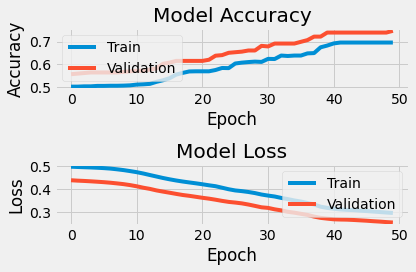

0.7474(max: 0.7474)
Done.


In [19]:
%time
# Plot accuracy
plt.subplot(211)
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(212)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout(h_pad=1.0)
plt.savefig('./data/history-graph_' + str(num_samples) + '.png')
plt.show()

print(str(malstm_trained.history['val_acc'][-1])[:6] +
      "(max: " + str(max(malstm_trained.history['val_acc']))[:6] + ")")
print("Done.")

## 4. Predicting 

In [20]:
model = tf.keras.models.load_model('./data/SiameseLSTM_' + str(num_samples) + '.h5', custom_objects={'ManDist': ManDist})
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None

### 4.1 Finding the most similar text

In [21]:
%time
matching_questions = []

choosen_question_id = test_df['question1_id'].to_list()[0]
print(choosen_question_id)
    
choosen_question_mask = test_df['question1_id'].values == choosen_question_id
print(len(test_df[choosen_question_mask]))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
825282
9


In [22]:
# Split to dicts and append zero padding.
X_test = split_and_zero_padding(test_df[choosen_question_mask], max_seq_length)

# Make sure everything is ok
assert X_test['left'].shape == X_test['right'].shape
# --

prediction = model.predict([X_test['left'], X_test['right']])
closests_text = np.argmax(prediction)
most_similar_text = test_df[choosen_question_mask][:1]
print(most_similar_text['question1'].values[0][:200])
print(most_similar_text['question2'].values[0][:200])

processo recorrente rosineide correia lima recorridoa uniao federal juiz sentenciante camila monteiro pullin milan votoementa administrativo processual civil servidores aposentados pensionistas extint
judiciario justica federal assiste razao autora revista pensao morte devendo pago salariodebeneficio face exposto julgo procedente pedido revisar beneficio pensao morte autora obrigacao devendo fixado


## 5. Bibliography

Siamese-LSTM. Sang-Kil Park. [Available at](https://github.com/likejazz/Siamese-LSTM) Last visited: 17/04/2020
